## Assignment 3 Question 2

Is it possible to predict ELO of a player based on context of a potential en passant move?

Only investigating the player who is in the position of making the en passant move.

Lila See FDS PCA solutions for 3 good points for what PCA is good for - include in report?

#### Import Libraries

In [40]:
import pandas as pd
import chess
import chess.pgn
import chess.engine
import io
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time

import data_cleaning

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### Import stockfish 🐟🐟🐟

In [41]:
STOCKFISH_LOC = os.getcwd() + "\stockfish\stockfish-windows-2022-x86-64-avx2.exe"
print(STOCKFISH_LOC)
from stockfish import Stockfish
fish = Stockfish(path=STOCKFISH_LOC)

c:\Users\Leon\OneDrive - University of Edinburgh\Year 2\Computer Science\Foundations of Data Science\fds-assignment-3\stockfish\stockfish-windows-2022-x86-64-avx2.exe


#### Import CSV file

66879 entries in dataframe

In [42]:
chess_data = data_cleaning.import_data()
print(chess_data.dtypes)

white_username    object
black_username    object
white_id          object
black_id          object
white_rating       int64
black_rating       int64
white_result      object
black_result      object
time_class        object
time_control      object
rules             object
rated               bool
fen               object
pgn               object
dtype: object


#### Dataframe info

Using:
print(chess_data.dtypes)
print(chess["rules"].unique())


Chess rules:
['chess' 'chess960' 'threecheck' 'crazyhouse' 'kingofthehill']

Time control:
['1/259200' '1/172800' '1800' '1/86400' '1/432000' '1/604800' '600'
 '120+1' '900+10' '300' '180+2' '3600+5' '2700+45' '3600' '1/1209600'
 '180' '600+10' '60' '480+3' '300+5' '420+3' '600+5' '600+2' '1200' '30'
 '60+1' '120' '1500+3' '900+2' '1500+5' '1500+10' '1/864000' '900' '300+2'
 '1500' '7200' '300+1' '5400' '3600+60' '2700+30' '3480+45' '10' '2700+10'
 '15' '2700' '3600+20' '4500' '4200' '900+5' '1800+10' '2700+5' '480+5'
 '1800+30' '300+3' '600+1' '1800+5' '420+5' '5400+30' '240+10' '420' '303'
 '60+10']

 Time class:
['daily' 'rapid' 'bullet' 'blitz']

#### Clean data

Undeveloped board shouldn't matter if we're filtering games for potential ep

Same for draws

Can filter our time class if are looking at time controls

After making a new move_list column, should we drop the pgn column?


Variables we are considering when predicting ELO (for a player who could potentially make en passant move) are: (Y = DONE, N = NOT DONE)
- Y: Colour who had ep opportunity (boolean)
- Y: Did they take the en passant? (boolean)
- N: Does their choice on taking/not taking support them if gaining an advantage? (numerical value for how much of an advantage it gives)
- N: Time taken to decide to capture/not capture en passant (... whatever can be time, a number in seconds ig)
- Y: Is the game rated? (boolean)
- Y: Game time class


To do:
- Work out which colour is making the potential en passant move, add a column to dataframe detailing this
- Make dataframe columns for other variables
- Apply PCA reduction

In [43]:
# Save PGN column from dataframe
full_pgn = chess_data['pgn']

def get_moves(entry):
    '''
    Retrive series of moves in a game when given the whole full_pgn entry
    '''
    pgn = entry.splitlines()[-1]
    return pgn

# Add list of moves (string) as a new column to dataframe
chess_data['move_list'] = full_pgn.apply(get_moves)
# Drop irrelevant columns
chess_data = chess_data.drop(['time_control', 'white_username', 'black_username','white_id', 'black_id', 'white_result', 'black_result', 'rules'], axis=1)

In [44]:
print(chess_data.iloc[0])

white_rating                                                 1708
black_rating                                                 1608
time_class                                                  daily
rated                                                        True
fen             r2r4/p2p1p1p/b6R/n1p1kp2/2P2P2/3BP3/PP5P/4K2R ...
pgn             [Event "Enjoyable games 2 - Round 1"]\n[Site "...
move_list       1. d4 Nf6 2. c4 e6 3. Nc3 Bb4 4. Qb3 Bxc3+ 5. ...
Name: 0, dtype: object


#### Import chess info
https://python-chess.readthedocs.io/en/latest/core.html#chess.Board.san


#### En Passant functions
- has_legal_en_passant() tests if en passant capturing would actually be possible on the next move.
- has_pseudo_legal_en_passant()
- has_legal_en_passant()
- is_en_passant(move: Move) Checks if the given pseudo-legal move is an en passant capture.




Use StringIO to parse games from a string.

```python
import io
pgn = io.StringIO("1. e4 e5 2. Nf3 *")
game = chess.pgn.read_game(pgn)
```

#### Clean data specifically for ep

Filter out columns that don't have potential ep
Add columns for: whether ep happened, which colour had potential to take ep

In [45]:
def check_pgn(df_row):
    '''
    Checks PGN for whether opportunity for EP happened in the game.
    '''
    
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    # pre-initialise df_row values
    precheck = False
    moved = False
    move_colour = ""
    
    # comparison sets when checking move piece
    ep_set = set(["ax","bx","cx","dx","ex","fx","gx", "hx"])
    check_set = set("abcdefgh")
    
    # Find only pawn moves in game
    for move in game.mainline_moves():
        san = board.san(move)
        turn = board.turn
        move_piece = san[0]
        # check if precheck was flagged in previous move
        if precheck:
            # get first 2 letters, and compare to a set
            move_ep_piece = san[:2]
            if move_ep_piece in ep_set:
                # check if e.p. actually happened
                moved = board.is_en_passant(move)
            # break out for loop, no need to check further
            break
        
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
            # if precheck is true then set the turn
            if precheck:
                if turn:
                    move_colour = 'Black'
                else:
                    move_colour = 'White'
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)
    
    # set row values
    df_row["ep_opportunity"] = precheck
    df_row["ep_happened"] = moved
    df_row["ep_colour"] = move_colour
    return df_row

chess_filter = chess_data.copy(deep=True)

start = time.time()
# apply e.p. finding function
chess_filter = chess_filter.apply(check_pgn, axis=1)
end = time.time()
print(end - start)

353.82040548324585


In [46]:
chess_filter = chess_filter[chess_filter['ep_opportunity'] == True]
chess_filter = chess_filter.drop(['ep_opportunity'], axis=1)
chess_filter = chess_filter[chess_filter['time_class'] != "daily"]
chess_filter = chess_filter.reset_index(drop=True)
print(len(chess_filter))
print(len(chess_filter[chess_filter['ep_happened'] == True]))
# print(chess_filter["move_list"].sample(50).head(20))

5074
1563


In [47]:
# print(chess_filter.values)

In [48]:
samp = chess_filter.sample(10)

#### Cleaning data for EP - Advantage for ep

Analysing game - finding if ep move would have given an edvantage


Split into cases: ep happened and ep didn't happen


NOT DONE YET

In [64]:
def increment_letter(letter):
    '''dumb increment func'''
    match letter:
        case "a":
            return "b"
        case "b":
            return "c"
        case "c":
            return "d"
        case "d":
            return "e"
        case "e":
            return "f"
        case "f":
            return "g"
        case "g":
            return "h"
        case "h":
            return "z"

def decrement_letter(letter):
    '''dumb decrement func'''
    match letter:
        case "a":
            return "y"
        case "b":
            return "a"
        case "c":
            return "b"
        case "d":
            return "c"
        case "e":
            return "d"
        case "f":
            return "e"
        case "g":
            return "f"
        case "h":
            return "g"

def get_advantage(df_row):
    # make board
    # find move with e.p.
    # stockfish eval at that point
    # get stockfish eval if best move
    # get stockfish eval if e.p.
    # find difference between two
    # return

    ep_set = set(["ax","bx","cx","dx","ex","fx","gx", "hx"])
    check_set = set("abcdefgh")

    
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    precheck = False
    
    pre_eval = 0
    post_eval_best = 0
    post_eval_ep = 0
    
    for move in game.mainline_moves():
        san = board.san(move)
        move_piece = san[0]

        # check if precheck was flagged in previous move
        if precheck:
            # set stockfish on position
            fish.set_fen_position(board.fen())
            
            # get pre-move evaluation
            pre_eval = fish.get_evaluation()

            # get best move
            best_move = fish.get_best_move()
            
            # make best move and measure
            fish.make_moves_from_current_position([best_move])
            post_eval = fish.get_evaluation()
            # print(post_evaluation["value"])
            
            # get difference of best move
            post_eval_best_diff = post_eval["value"] - pre_eval["value"]


            col = df_row["ep_colour"]
            print(col)


            print("board peek: " + str(board.peek()))
            # get previous move
            pawn_move_row = str(board.peek())[-2]
            pawn_move_col = str(board.peek())[-1]
            ep_result_col = "3" if pawn_move_col == "4" else "6"

            # get left and right square relative to pawn that just moved
            left_square = decrement_letter(pawn_move_row) + pawn_move_col
            right_square = increment_letter(pawn_move_row) + pawn_move_col

            print("leftsq: " + left_square)
            print("righsq: " + right_square)

            # checks if in leftmost or rightmost file
            left_bound = True if left_square[-2] == "y" else False
            right_bound = True if right_square[-2] == "z" else False

            # if the piece to the left of the moved pawn is also a pawn
            ep_left = False
            # if the piece to the right of the moved pawn is also a pawn
            ep_right = False

            if col == "Black":
                FISH_PAWN = fish.Piece.BLACK_PAWN
            else:
                FISH_PAWN = fish.Piece.WHITE_PAWN

            # gross conditional :/
            fish.set_fen_position(board.fen())

            # if somewhere in the middle
            if (not left_bound) and (not right_bound):
                left_sq_piece = fish.get_what_is_on_square(left_square)
                right_sq_piece = fish.get_what_is_on_square(right_square)
                print("left sq:" + str(left_sq_piece))
                print("right sq: " + str(right_sq_piece))
                # if left of square is white pawn or black pawn
                if left_sq_piece == FISH_PAWN:
                    ep_left = True
                # if right of square is white pawn or black pawn
                if right_sq_piece == FISH_PAWN:
                    ep_right = True
            
            # if A file pawn (leftmost)
            elif left_bound:
                right_sq_piece = fish.get_what_is_on_square(right_square)
                
                # if right of square is white pawn or black pawn
                if right_sq_piece == FISH_PAWN:
                    ep_right = True
            
            # if H file pawn (rightmost)
            elif right_bound:
                left_sq_piece = fish.get_what_is_on_square(left_square)
                
                # if left of square is white pawn or black pawn
                if left_sq_piece == FISH_PAWN:
                    ep_left = True

            print(ep_left)
            print(ep_right)

            # low low post_eval value in case there are two diff e.p. states
            post_eval_ep = -100000
            
            # if left side e.p.
            if ep_left:
                # reset board
                fish.set_fen_position(board.fen())
                # concat a move
                ep_move = decrement_letter(pawn_move_row) + pawn_move_col + pawn_move_row + ep_result_col
                # make the move on stockfish
                fish.make_moves_from_current_position([ep_move])
                # get the maximum centipawns
                post_eval_ep = max(post_eval_ep, fish.get_evaluation()["value"])
            
            # if right side e.p.
            if ep_right:
                # reset board
                fish.set_fen_position(board.fen())
                # concat a move
                ep_move = increment_letter(pawn_move_row) + pawn_move_col + pawn_move_row + ep_result_col
                # make the move on stockfish
                fish.make_moves_from_current_position([ep_move])
                # get the maximum centipawns
                post_eval_ep = max(post_eval_ep, fish.get_evaluation()["value"])
            
            # calculate difference
            post_eval_ep_diff = post_eval["value"] - pre_eval["value"]

            break
            
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)

    df_row["pre_state"] = pre_eval["value"]
    df_row["state_best"] = post_eval_best_diff# stockfish eval if e.p. is taken
    df_row["state_ep"] = post_eval_ep_diff # stockfish eval if e.p. isn't taken
    return df_row

# increment_letter("a")
# print(get_advantage(chess_filter.iloc[0]))
samp2 = samp.apply(get_advantage, axis=1)

Black
board peek: b2b4
leftsq: a4
righsq: c4
left sq:None
right sq: Piece.BLACK_PAWN
False
True
White
board peek: g7g5
leftsq: f5
righsq: h5
left sq:Piece.WHITE_PAWN
right sq: None
True
False
Black
board peek: h2h4
leftsq: g4
righsq: z4
True
False
White
board peek: d7d5
leftsq: c5
righsq: e5
left sq:Piece.BLACK_PAWN
right sq: Piece.WHITE_PAWN
False
True
White
board peek: c7c5
leftsq: b5
righsq: d5
left sq:None
right sq: Piece.WHITE_PAWN
False
True
White
board peek: d7d5
leftsq: c5
righsq: e5
left sq:None
right sq: Piece.WHITE_PAWN
False
True
White
board peek: f7f5
leftsq: e5
righsq: g5
left sq:Piece.WHITE_PAWN
right sq: None
True
False
Black
board peek: h2h4
leftsq: g4
righsq: z4
True
False
Black
board peek: d2d4
leftsq: c4
righsq: e4
left sq:None
right sq: Piece.BLACK_PAWN
False
True
White
board peek: f7f5
leftsq: e5
righsq: g5
left sq:Piece.BLACK_PAWN
right sq: Piece.WHITE_PAWN
False
True


In [65]:
print(samp2)

      white_rating  black_rating time_class  rated  \
4247           697           727      blitz   True   
2583           994          1023      rapid   True   
1247          1298          1230      rapid   True   
2385          1084          1124      blitz   True   
3113          1329          1406      blitz   True   
756           1563          1613     bullet   True   
2321          1582          1483      blitz   True   
4816           780           795      blitz   True   
3118          1297          1039      blitz   True   
2783          1539          1567      rapid   True   

                                                    fen  \
4247         5r2/8/2n5/1p1N4/pP1P2k1/P1PKP3/6P1/8 w - -   
2583  3rk2r/p3bp2/q1np1B2/4pP2/1p2P2p/2N4P/PPP1N1P1/...   
1247  4kr1r/1p3p2/2p1p3/4P2R/p2b2p1/Pb6/6P1/4BR1K w - -   
2385               8/8/p3pk2/3p3p/5P1K/2r5/6P1/7r w - -   
3113  r4rk1/1b1p4/1pP2p1p/p3n2p/3B4/1B4P1/PP5P/R4RK1...   
756        1r1b4/3P2k1/p1N5/3P1p1B/5P2/P5K1/6PP/8 b

### Number of games with at least 1 possible en-passant move - ???:
## 4750
(maybe 4913 or even 4945)

### Number of games with an actual en-passant move - ???:
## 1566

#### Applying PCA


In [ ]:
# Replace Boolean and string variables with numbers
chess_filter['ep_happened'] = chess_filter['ep_happened'].replace({True:1, False:0})
chess_filter['ep_colour'] = chess_filter['ep_colour'].replace({'White':1, 'Black':0})
chess_filter['rated'] = chess_filter['rated'].replace({True:1, False:0})
chess_filter['time_class'] = chess_filter['time_class'].replace({'daily':3, 'rapid':2, 'blitz':1, 'bullet':0})

# Drop irrelevant columns, and save differently - as a dataframe including the rating and one without
chess_data_with_elo = chess_filter.drop(['fen', 'pgn', 'move_list'], axis=1)
chess_data_without_elo = chess_data_with_elo.drop(['white_rating', 'black_rating'], axis=1)

print(chess_data_with_elo.head())
print('\n')
print(chess_data_without_elo.head())

   white_rating  black_rating  time_class  rated  ep_happened  ep_colour
0          1498          1540           2      1            0          1
1          1505          1485           2      1            1          0
2          1239          1177           0      1            0          0
3          1485          1531           2      1            1          0
4          1536          1523           2      1            1          0


   time_class  rated  ep_happened  ep_colour
0           2      1            0          1
1           2      1            1          0
2           0      1            0          0
3           2      1            1          0
4           2      1            1          0


##### Data Standardisation (For PCA)

Cite week 8 lab sheet in report? Heavily used their code to help

Text(0, 0.5, 'PC2')

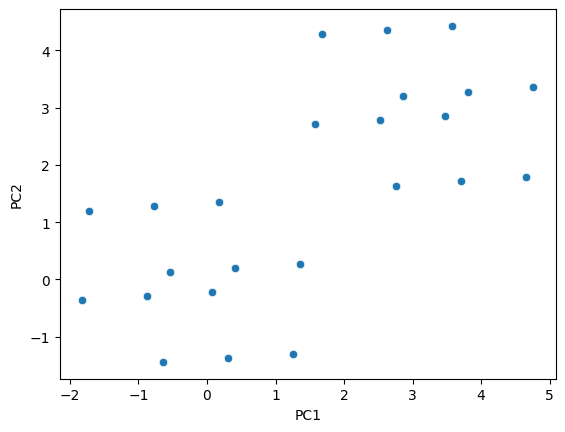

In [ ]:
# THIS PART IS COPIED AND PASTED FROM WEEK 8 PCA SOLUTIONS:
def sort_eigenvalues(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    return eigenvalues, eigenvectors

# THE REST IS HEAVILY INFLUENCED BY WEEK 8 PCA SOLUTIONS

# Standardise chess_data_without_elo so that it follows the Standard normal distribution
for col in chess_data_without_elo.columns:
        chess_data_without_elo[col] = (chess_data_without_elo[col] - chess_data_without_elo[col].mean()) / chess_data_without_elo[col].std()

# # Create matrix storing covariances of the chess dataframe features
# covariances = np.cov(chess_data_without_elo.values.T)

# # Record eigenvalues and eigenvectors
# eigenvalues, eigenvectors = np.linalg.eig(covariances)
# eigenvalues, eigenvalues = sort_eigenvalues(eigenvalues, eigenvectors)

# result = chess_data_without_elo.dot(eigenvectors[:,:2])

# sns.scatterplot(x= result[0], y = result[1], hue=diagnosis)
# plt.xlabel('PC1')
# plt.ylabel('PC2')




# Lila Can we instead use this? :
pca = PCA(n_components=3).fit(chess_data_without_elo.values)
pca_result = pca.transform(chess_data_without_elo.values)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')